In [22]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import tensorflow.math as tfmath

In [75]:
l = 4
m = 1

In [76]:
num_dense_nodes = 50
num_dense_layers = 7

In [77]:
def z_component(phi):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(phi * m * 1j)

In [78]:
def theta_part(theta):
    # 2*pi is already at the z_component
    normalization_constant = ((-1) ** m) * np.sqrt(((2 * l + 1) / 2) * (np.math.factorial(l - m) / np.math.factorial(l + m)))
    legendre_values = []
    for i in theta:
        legendre_polynomials, _ = sp.lpmn(m, l, np.cos(i[0]))
        legendre = legendre_polynomials[m, l]
        legendre_values.append([legendre])
    legendre_values = np.array(legendre_values)
    
    return normalization_constant * legendre_values

In [79]:
def spherical_harmonic(x):
    theta, phi = x[:, 0:1], x[:, 1:2]
    
    legendre_component = theta_part(theta)
    phi_component = z_component(phi)
    
    return legendre_component * phi_component

In [80]:
def pde(x, y):
    dy_theta = dde.grad.jacobian(y, x, i=0, j=0)
    dy_thetatheta = dde.grad.hessian(y, x, i=0, j=0)
    
    cos_theta = tfmath.cos(x)
    sin_theta = tfmath.sin(x)
    
    # be aware that sometimes it is better to multiply both sides to avoid points with division by 0, i.e. here,
    # to multiply both sides by sin^2 theta, as in normal form of this equation it divides m^2 what led to
    # NaNs during training process
    return (sin_theta ** 2) * dy_thetatheta + (cos_theta * sin_theta) * dy_theta + ((sin_theta ** 2) * l * (l + 1) - (m ** 2)) * y

In [81]:
domain = dde.geometry.Interval(0, np.pi)

In [82]:
def get_collocation_points(l):
    theta_values = []
    
    theta_interval = np.pi / (3 * l)
    
    for k in range(3 * l - 1):
        theta = (k + 1) * theta_interval
        theta_values.append(theta)
    
    return np.array(theta_values).reshape((3 * l - 1, 1))

In [83]:
collocation_points = get_collocation_points(l)
collocation_values = theta_part(collocation_points)

collocation_values

array([[ 1.04683909e+00],
       [ 1.15535227e+00],
       [ 2.96463531e-01],
       [-6.41862372e-01],
       [-7.50375556e-01],
       [-2.17837868e-16],
       [ 7.50375556e-01],
       [ 6.41862372e-01],
       [-2.96463531e-01],
       [-1.15535227e+00],
       [-1.04683909e+00]])

In [84]:
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)

In [85]:
def boundary(x, on_boundary):
    return on_boundary

In [86]:
periodic_bc = dde.icbc.PeriodicBC(domain, 0, boundary)

In [87]:
bcs = [ic, periodic_bc]

In [88]:
num_train = 64
num_test = 100
num_boundary = 2

In [89]:
data = dde.data.PDE(
    domain,
    pde,
    bcs,
    num_domain=num_train,
    num_boundary=num_boundary,
    solution=theta_part,
    num_test=num_test
)

In [90]:
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.nn.FNN(
    [1] + [num_dense_nodes] * num_dense_layers + [1],
    activation,
    initializer
)

In [91]:
loss_weights = [1, 100, 100]

model = dde.Model(data, net)
model.compile(
    'adam',
    lr=0.0001,
    metrics=['l2 relative error'],
    loss_weights=loss_weights
)

Compiling model...
Building feed-forward neural network...
'build' took 0.131325 s



2023-07-27 09:45:38.465811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 09:45:38.466157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 09:45:38.466378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 0.869974 s



In [1]:
loss_history, train_state = model.train(iterations=20000)

NameError: name 'model' is not defined

Saving loss history to /home/piotr/repos/quant-chem-pinns/rigid-rotor/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/rigid-rotor/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/rigid-rotor/test.dat ...


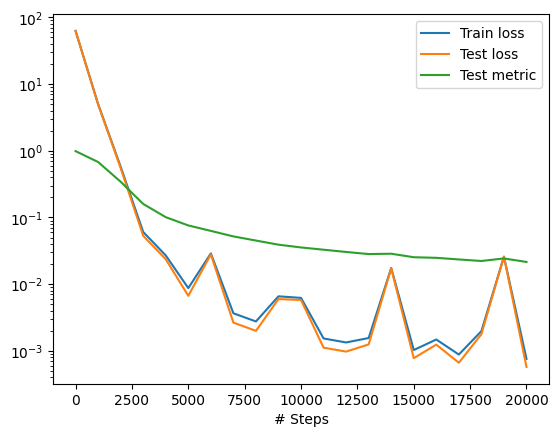

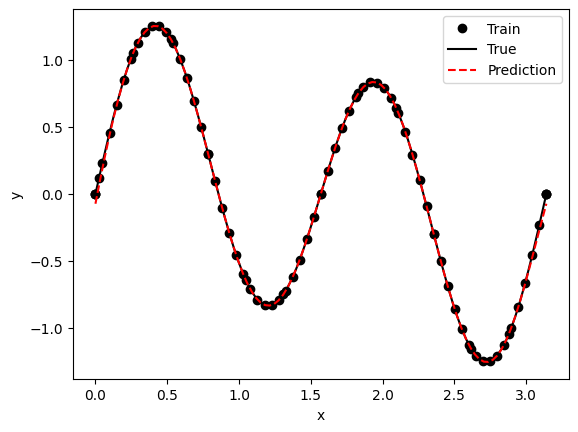

In [93]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [94]:
def spherical_harmonic_model(x):
    theta, phi = x[:, 0:1], x[:, 1:2]
    theta_part = model.predict(theta)
    phi_part = z_component(phi)
    
    return theta_part * phi_part

In [95]:
def diff_function(x):
    model_value = spherical_harmonic_model(x)
    true_value = spherical_harmonic(x)
    return np.abs(model_value - true_value)

In [96]:
diff_function(np.array([[0.0, 0.0], [1.0, 0.0]]))

array([[2.96014892e-02],
       [2.92000026e-06]])

In [97]:
def plot_2d_map(plotted_function, grid_dist=0.01):
    x_ax = np.arange(0, np.pi, grid_dist)
    y_ax = np.arange(0, 2 * np.pi, grid_dist)
    grid_x, grid_y = np.meshgrid(x_ax, y_ax)
    
    diff_list = []
    for a, b in zip(grid_x, grid_y):
        pair_list = []
        for x, y in zip(a, b):
            pair_list.append([x, y])
        pairs = np.array(pair_list)
        diff_list.append(np.squeeze(plotted_function(pairs)))

    diff_list = np.abs(np.array(diff_list))
    
    im = plt.imshow(diff_list, cmap=plt.cm.RdBu)
    plt.colorbar(im)

    plt.show()

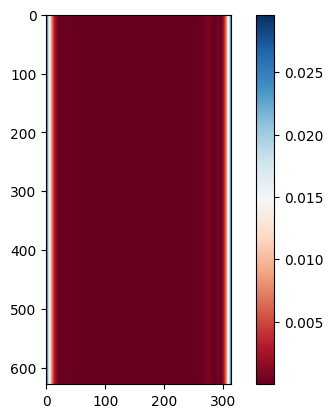

In [98]:
plot_2d_map(diff_function)

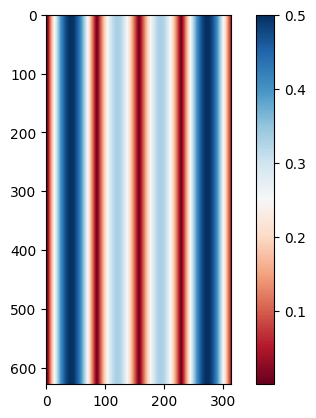

In [99]:
plot_2d_map(spherical_harmonic_model)

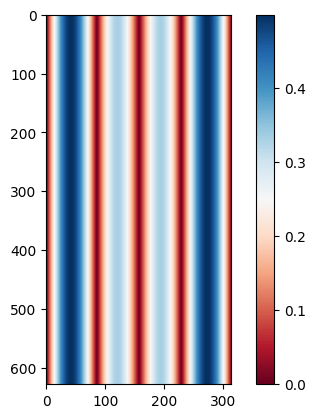

In [100]:
plot_2d_map(spherical_harmonic)